In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import sys
from anndata import AnnData

# sys.path.append("/home/icb/giovanni.palla/code/spatial-alignment/data")
# from data.simulated.generate_twod_data import generate_twod_data_partial_overlap

%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
adata = sc.read(
    "/lustre/groups/ml01/workspace/giovanni.palla/moscot/data/alignment.h5ad"
)

adata = adata[adata.obs.synth_batch == "6"].copy()
# arr_obs = np.repeat(np.arange(adata.shape[0] / 2)[:, None], adata.shape[1], 1)
# arr_obs = np.vstack([arr_obs.copy(), arr_obs.copy()])

# arr_var = np.repeat(np.arange(adata.shape[1] / 2)[None, :], adata.shape[0], 0)
# arr_var = np.hstack([arr_var.copy(), arr_var.copy()])

# adata.X = adata.X.copy() + arr_obs + arr_var
adata.X = np.random.normal(size=adata.X.shape) + adata.X.copy()
p = 0.8
idx_subsample = np.random.choice([True, False], size=(adata.shape[0]), p=[p, 1 - p])
adata = adata[idx_subsample].copy()
# sc.pp.pca(adata)
# adata = adata[~((adata.obs.idx == 100) & (adata.obs.batch == 0))].copy()
# sc.pp.subsample(adata, fraction=0.999)


adata

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 2559 × 500
    obs: 'batch', 'idx', 'synth_batch'
    obsm: 'spatial'

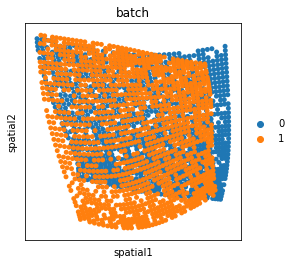

In [4]:
sc.pl.spatial(adata, spot_size=0.1, color="batch")

In [14]:
import moscot as mt

2023-01-11 11:42:25.877115: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2023-01-11 11:42:25.976807: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


In [29]:
adata = sq.datasets.visium_fluo_adata_crop()
adata2 = adata.copy()
adata2.obsm["spatial"] = adata2.obsm["spatial"] @ np.array([[0, -1], [1, 0]])

In [30]:
adata2

AnnData object with n_obs × n_vars = 704 × 16562
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

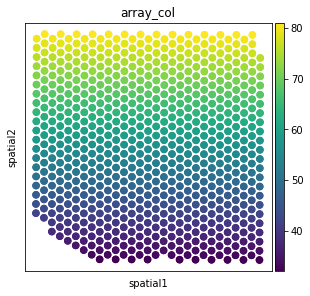

In [31]:
sq.pl.spatial_scatter(adata2, shape=None, color="array_col")

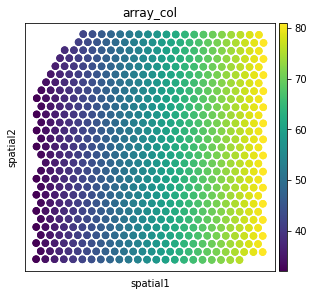

In [32]:
sq.pl.spatial_scatter(adata, shape=None, color="array_col")

In [33]:
import paste as pst

pi12 = pst.pairwise_align(adata, adata2, norm=True)

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


In [34]:
new_slices = pst.stack_slices_pairwise([adata, adata2], [pi12])

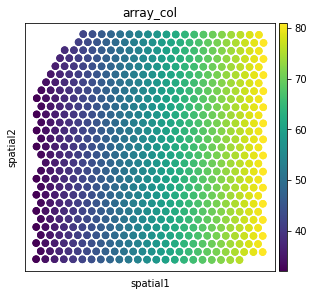

In [36]:
sq.pl.spatial_scatter(new_slices[1], shape=None, color="array_col")

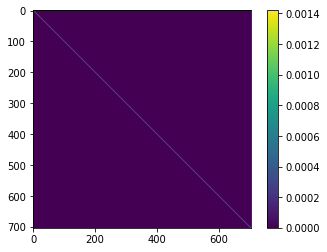

In [37]:
plt.imshow(pi12)
plt.colorbar()

In [9]:
import paste as pst

# adata.X[adata.X < 0] = 0
batch1 = adata[adata.obs.batch == 0].copy()
batch2 = adata[adata.obs.batch == 1].copy()

pi12 = pst.pairwise_align(batch1, batch2)  # , dissimilarity="euclidean")

Using selected backend cpu. If you want to use gpu, set use_gpu = True.


/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/ot/backend.py:969: RuntimeWarning: invalid value encountered in log
  return np.log(a)
/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/ot/lp/__init__.py:343: UserWarning: Problem unbounded
  result_code_string = check_result(result_code)


In [44]:
batch1.X.max(), batch1.X.min()

(6.559554218222603, -6.600413116120352)

In [69]:
# slices, pis = [batch1, batch2], [pi12]
# new_slices = pst.stack_slices_pairwise(slices, pis)

In [6]:
pi12norm = pi12 / pi12.sum(0)
out = (batch1.obsm["spatial"].T @ pi12norm).T
batch1.obsm["spatial_warp"] = batch1.obsm["spatial"]
batch2.obsm["spatial_warp"] = out

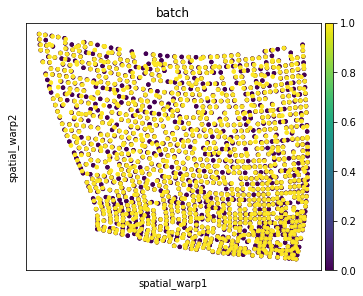

In [7]:
import squidpy as sq
import anndata as ad

adata_aligned = ad.concat([batch1, batch2])
# adata_aligned = ad.concat(new_slices)
sq.pl.spatial_scatter(
    adata_aligned, shape=None, color="batch", spatial_key="spatial_warp"
)

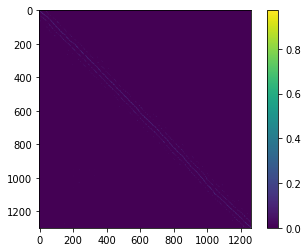

In [8]:
plt.imshow(pi12norm)
plt.colorbar()

In [61]:
adata = sq.datasets.visium_fluo_adata_crop()
# sc.pp.normalize_total(ada)

<704x16562 sparse matrix of type '<class 'numpy.float32'>'
	with 3228307 stored elements in Compressed Sparse Row format>

In [ ]:
sc.pp.normalize_per_cell()

In [94]:
pi12norm.max()

0.0007727975270479086

In [ ]:
import moscot as mt

In [12]:
batch1

AnnData object with n_obs × n_vars = 1264 × 500
    obs: 'batch', 'idx', 'synth_batch'
    uns: 'batch_colors'
    obsm: 'spatial'

In [10]:
batch1

AnnData object with n_obs × n_vars = 0 × 500
    obs: 'batch', 'idx', 'synth_batch'
    uns: 'batch_colors'
    obsm: 'spatial'

In [9]:
import ot

ot.__version__

'0.8.2'

In [ ]:
N_SPATIAL_DIMS = 2
N_VIEWS = 2
M_G = 50
M_X_PER_VIEW = 50
N_OUTPUTS = 5
FIXED_VIEW_IDX = 0
N_LATENT_GPS = {"expression": None}

N_EPOCHS = 1000
PRINT_EVERY = 100

model = VariationalGPSA(
    data_dict,
    n_spatial_dims=N_SPATIAL_DIMS,
    m_X_per_view=M_X_PER_VIEW,
    m_G=M_G,
    data_init=True,
    minmax_init=False,
    grid_init=False,
    n_latent_gps=N_LATENT_GPS,
    mean_function="identity_fixed",
    kernel_func_warp=rbf_kernel,
    kernel_func_data=rbf_kernel,
    fixed_view_idx=FIXED_VIEW_IDX,
).to(device)

view_idx, Ns, _, _ = model.create_view_idx_dict(data_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
def train(model, loss_fn, optimizer):
    model.train()

    # Forward pass
    G_means, G_samples, F_latent_samples, F_samples = model.forward(
        {"expression": x}, view_idx=view_idx, Ns=Ns, S=5
    )

    # Compute loss
    loss = loss_fn(data_dict, F_samples)

    # Compute gradients and take optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), G_means


for t in range(N_EPOCHS):
    loss, G_means = train(model, model.loss_fn, optimizer)
print("Done!")

/mnt/home/icb/giovanni.palla/code/spatial-alignment/gpsa/models/vgpsa.py:249: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).transpose(-2, -1).conj().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1285.)
  self.curr_Omega_tril_list = torch.cholesky(curr_Omega_G)


In [14]:
G_means["expression"].detach().numpy()

array([[-1.4386377, -1.7534232],
       [-1.3802589, -1.752886 ],
       [-1.262732 , -1.7510846],
       ...,
       [ 1.8501592,  1.9056758],
       [ 1.9781213,  1.9014939],
       [ 2.1097858,  1.8954253]], dtype=float32)

In [16]:
adata.obsm["spatial_aligned"] = G_means["expression"].detach().numpy()

In [24]:
adata.obsm["spatial_aligned"].shape

(2532, 2)

In [25]:
adata.shape

(2532, 500)

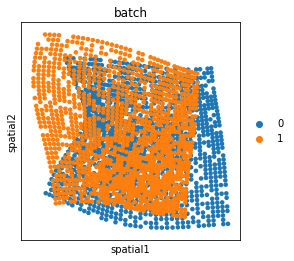

In [20]:
sc.pl.spatial(adata, spot_size=0.1, color="batch")

In [21]:
adata_gpsa = adata.copy()

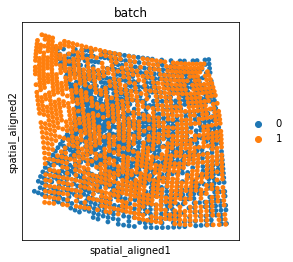

In [22]:
sc.pl.spatial(adata, basis="spatial_aligned", spot_size=0.1, color="batch")

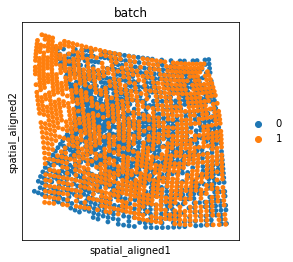

In [26]:
sc.pl.spatial(adata_gpsa, basis="spatial_aligned", spot_size=0.1, color="batch")

In [51]:
adata.shape

(2532, 500)

In [28]:
from sklearn.metrics import mean_squared_error

ad1 = adata[adata.obs.batch == 0].copy()
ad2 = adata[adata.obs.batch == 1].copy()
inter, comm1, comm2 = np.intersect1d(ad1.obs.idx, ad2.obs.idx, return_indices=True)
mean_squared_error(
    ad1.obsm["spatial_aligned"][comm1][:, 1], ad2.obsm["spatial_aligned"][comm2][:, 1]
)

0.037498698

In [29]:
adata.obsm

AxisArrays with keys: spatial, spatial_aligned

In [30]:
from moscot.problems.space._alignment import SpatialAlignmentProblem
from moscot.backends.ott import FGWSolver, SinkhornSolver, GWSolver

prob = SpatialAlignmentProblem(adata)
prob.prepare(
    key="batch",
    # attr_joint={"x_attr": "obsm", "x_key": "X_pca", "y_attr": "obsm", "y_key": "X_pca"},
)

In [31]:
prob.solve(epsilon=1e-2, alpha=0.5)

2022-03-01 16:01:38.946091: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-10.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-10.2/extras/CUPTI/lib64:/usr/local/cuda-10.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-10.2/extras/CUPTI/lib64:/usr/local/cuda-10.2/lib64:/usr/local/cuda/lib64:/usr/local/cuda-10.2/extras/CUPTI/lib64
2022-03-01 16:01:38.946538: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
/mnt/home/icb/giovanni.palla/code/moscot/moscot/solvers/_utils.py:26: UserWarning: Target marginals are not satisfied within rtol=0.001, atol=0.001.
  warnings.warn(msg)


In [32]:
ad1 = adata[adata.obs.batch == 0].copy()
ad2 = adata[adata.obs.batch == 1].copy()
print(ad1.shape, ad2.shape)

(1283, 500) (1249, 500)


In [33]:
prob.solution

{(0, 1): <moscot.problems._base_problem.GeneralProblem at 0x7fc7ee222460>}

In [34]:
prob.solution[(0, 1)].solution

GWOutput[shape=(1283, 1249), cost=986.6383, converged=True]

(-0.5, 99.5, 99.5, -0.5)

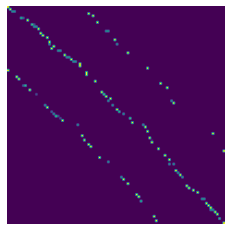

In [50]:
import seaborn as sns

k = (0, 1)
p = prob.solution[k].solution.transport_matrix
plt.imshow(p[0:100, 0:100])
plt.axis("off")

In [36]:
np.count_nonzero(p)

1861

In [37]:
p.shape

(1283, 1249)

In [38]:
Y = ad2.obsm["spatial"]
p = prob.solution[k].solution.transport_matrix
p = p / p.sum(1)[:, None]
# X = ad2.obsm["spatial"][p.argmax(1)]
X = ad2.obsm["spatial"].T @ p.T
X = X.T
X.shape

(1283, 2)

In [39]:
print(p.argmax(1).shape, ad1.shape)

(1283,) (1283, 500)


In [40]:
adata.obsm["spatial_aligned"] = np.vstack([X, Y])

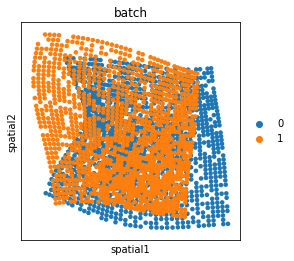

In [41]:
sc.pl.spatial(adata, spot_size=0.1, color="batch")

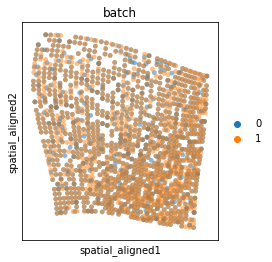

In [42]:
sc.pl.spatial(adata, basis="spatial_aligned", alpha=0.5, spot_size=0.1, color="batch")

In [545]:
temp1 = ad1[ad1.obs.idx == 100].X.copy()
temp2 = ad2[ad2.obs.idx == 100].X.copy()

In [546]:
# np.testing.assert_array_equal(temp1, temp2)

In [547]:
adata.obs["idx"] = adata.obs.idx.astype("category").copy()

Trying to set attribute `._uns` of view, copying.


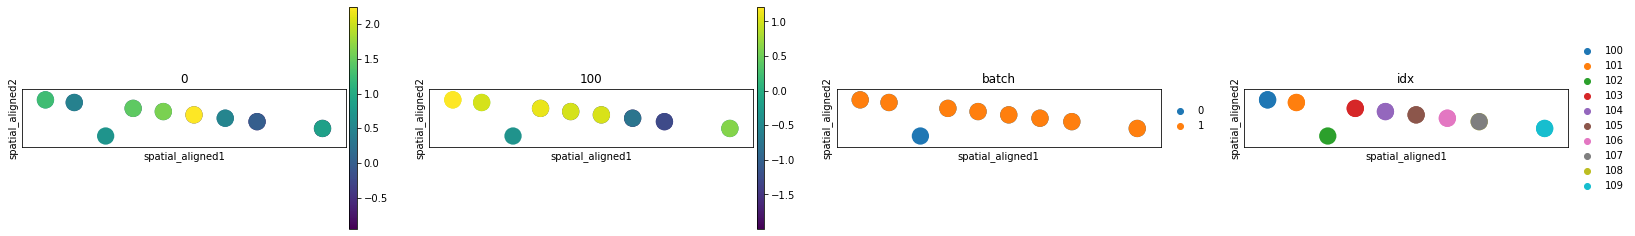

In [548]:
sc.pl.spatial(
    adata[adata.obs.idx.isin(np.arange(100, 110))],
    basis="spatial_aligned",
    spot_size=0.1,
    # alpha=0.5,
    color=["0", "100", "batch", "idx"],
)

In [549]:
adata.obsm["spatial_aligned"]

array([[-1.62262845, -1.31572342],
       [-1.54140055, -1.39159632],
       [-1.45816517, -1.46934438],
       ...,
       [ 1.43339378,  2.04233365],
       [ 1.62557376,  2.03879942],
       [ 2.01255657,  2.02336243]])

In [526]:
ad1.shape

(362, 500)

In [550]:
from sklearn.metrics import mean_squared_error

ad1 = adata[adata.obs.batch == 0].copy()
ad1_reorder = ad1[np.array(p.argmax(0))].copy()
ad2 = adata[adata.obs.batch == 1].copy()
ad2_reorder = ad2[np.array(p.argmax(1))].copy()
inter, comm1, comm2 = np.intersect1d(
    ad1_reorder.obs.idx.values, ad2_reorder.obs.idx.values, return_indices=True
)
mean_squared_error(
    ad1_reorder.obsm["spatial_aligned"][comm1],
    ad2_reorder.obsm["spatial_aligned"][comm2],
)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


0.0011066687303324327

In [527]:
from sklearn.metrics import mean_squared_error

ad1 = adata[adata.obs.batch == 0].copy()
ad1_reorder = ad1[np.array(p.argmax(0))].copy()
ad2 = adata[adata.obs.batch == 1].copy()
ad2_reorder = ad2[np.array(p.argmax(1))].copy()
inter, comm1, comm2 = np.intersect1d(
    ad1_reorder.obs.idx.values, ad2_reorder.obs.idx.values, return_indices=True
)
mean_squared_error(
    ad1_reorder.obsm["spatial_aligned"][comm1],
    ad2_reorder.obsm["spatial_aligned"][comm2],
)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


0.0009067070218120524

In [141]:
from sklearn.metrics import mean_squared_error

ad1 = adata[adata.obs.batch == 0].copy()
ad1_reorder = ad1[np.array(p.argmax(0))].copy()
ad2 = adata[adata.obs.batch == 1].copy()
ad2_reorder = ad2[np.array(p.argmax(1))].copy()
inter, comm1, comm2 = np.intersect1d(
    ad1_reorder.obs.idx.values, ad2_reorder.obs.idx.values, return_indices=True
)
mean_squared_error(
    ad1_reorder.obsm["spatial"][comm1],
    ad2_reorder.obsm["spatial"][comm2],
)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


0.3374995348554083

In [20]:
comm1

array([130451,  76878,  81378, ..., 180544, 177544,  49544])

In [337]:
from sklearn.metrics import mean_squared_error

ad1 = adata[adata.obs.batch == 0].copy()
ad2 = adata[adata.obs.batch == 1].copy()
inter, comm1, comm2 = np.intersect1d(ad1.obs.idx, ad2.obs.idx, return_indices=True)
mean_squared_error(
    ad1.obsm["spatial_aligned"][comm1], ad2.obsm["spatial_aligned"][comm2]
)

1.9667354780348272

In [113]:
ad1 = adata[adata.obs.batch == 0].copy()
ad2 = adata[adata.obs.batch == 1].copy()

In [115]:
ad1.obs.idx

299-2    299
303-2    303
40-6      40
236-2    236
389-2    389
        ... 
117-6    117
25-6      25
110-6    110
149-6    149
152-6    152
Name: idx, Length: 314, dtype: int64

In [123]:
ad1.obs.idx[comm1]

0-6        0
1-6        1
2-6        2
3-6        3
4-6        4
        ... 
393-2    393
394-2    394
395-2    395
397-2    397
399-2    399
Name: idx, Length: 259, dtype: int64

In [125]:
ad2.obs.idx[comm2]

400-2      0
401-2      1
402-2      2
403-2      3
404-2      4
        ... 
793-2    393
794-2    394
795-2    395
797-2    397
799-2    399
Name: idx, Length: 259, dtype: int64

In [148]:
k = list(prob.solution.keys())[0]
prob.solution[k].solution.transport_matrix.shape

(89, 91)

In [46]:
def generalized_procrustes_analysis_2D(X, Y, pi, output_params=True):
    """
    Finds and applies optimal rotation between spatial coordinates of two slices in 2D and returns the rotation angle and translation.

    param: X - np array of spatial coordinates (ex: sliceA.obs['spatial'])
    param: Y - np array of spatial coordinates (ex: sliceB.obs['spatial'])
    param: pi - mapping between the two layers output by PASTE
    Return: aligned spatial coordinates of X, Y, rotation angle, translation of X, translation of Y
    """
    assert X.shape[1] == 2 and Y.shape[1] == 2
    tX = pi.sum(axis=1).dot(X)
    tY = pi.sum(axis=0).dot(Y)
    X = X - tX  # X.mean(axis=0)
    Y = Y - tY  # Y.mean(axis=0)
    H = Y.T.dot(pi.T.dot(X))
    M = np.array([[0, -1], [1, 0]])
    theta = np.arctan(np.trace(M.dot(H)) / np.trace(H))
    # print('theta',theta*180/np.pi)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    Y = R.dot(Y.T).T
    if output_params:
        return X, Y, theta, tX, tY
    else:
        return X, Y

In [47]:
adata.obs.batch

0      0
1      0
2      0
3      0
4      0
      ..
195    1
196    1
197    1
198    1
199    1
Name: batch, Length: 200, dtype: category
Categories (2, int64): [0, 1]

In [8]:
adata[adata.obs.batch == "0"]

View of AnnData object with n_obs × n_vars = 0 × 500
    obs: 'batch', 'synth_batch'
    obsm: 'spatial'

In [9]:
ad1 = adata[adata.obs.batch == 0].copy()
ad2 = adata[adata.obs.batch == 1].copy()
X, Y, theta, tX, tY = generalized_procrustes_analysis_2D(
    ad2.obsm["spatial"],
    ad1.obsm["spatial"],
    prob.solution[k].solution.transport_matrix,
)

In [125]:
X = ad1.obsm["spatial"]
# Y = prob.solution[k].solution.transport_matrix.T @ ad2.obsm["spatial"]
# # Y = Y.T
# Y.shape

In [101]:
# Y = prob.pull(data=ad2.obsm["spatial"], scale_by_marginals=True)[k]
# out.shape

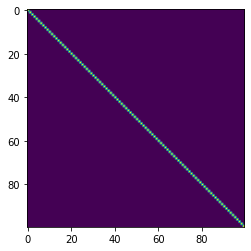

In [91]:
import seaborn as sns
p = prob.solution[k].solution.transport_matrix
p = np.array(prob.solution[k].solution.transport_matrix)
plt.imshow(p)

In [60]:
p = prob.solution[k].solution.transport_matrix
p = p / p.sum(1)[None, :]
p

DeviceArray([[1., 0., 0., ..., 0., 0., 0.],
             [0., 1., 0., ..., 0., 0., 0.],
             [0., 0., 1., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 1., 0., 0.],
             [0., 0., 0., ..., 0., 1., 0.],
             [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [75]:
new = ad1.X.T @ prob.solution[k].solution.transport_matrix
new.shape

(500, 100)

In [76]:
pi = prob.solution[k].solution.transport_matrix

In [78]:
pi.argmax(1)

DeviceArray([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
             15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
             30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
             45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
             60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
             75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
             90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int32)

In [ ]:
sc.pl.spatial(adata, basis="spatial_aligned", spot_size=0.5, color="batch")

In [4]:
adata_sp2 = adata_sp.copy()

In [5]:
sc.pp.subsample(adata_sc, fraction=0.05)
sc.pp.subsample(adata_sp, fraction=0.05)
sc.pp.subsample(adata_sp2, fraction=0.06)
print(adata_sc.shape, adata_sp.shape, adata_sp2.shape)

(670, 17135) (970, 351) (1164, 351)


In [6]:
# adata_sc.obs["batch"] = pd.Categorical(np.ones(adata_sc.shape[0]))
# adata_sp.obs["batch"] = pd.Categorical(np.ones(adata_sp.shape[0]))

In [7]:
adata_sp_joint = adata_sp.concatenate(adata_sp2, batch_key="batch")

In [15]:
adata_sc.obs["batch"] = 0

In [16]:
var_names = adata_sp_joint.var_names[0:10]

In [32]:
from moscot.problems.space._mapping import SpatialMappingProblem
from moscot.backends.ott import FGWSolver, SinkhornSolver, GWSolver

prob = SpatialMappingProblem(
    adata_sc=adata_sc, adata_sp=adata_sp_joint, var_names=var_names, use_reference=True
)
# prob

In [33]:
prob.prepare(key="batch")  # attr_sc =  {"attr": "obsm", "key": "X_scvi"})

In [34]:
prob._policy.plan()

{('0', <object at 0x7f58fcfdc2e0>): [('0', <object at 0x7f58fcfdc2e0>)],
 ('1', <object at 0x7f58fcfdc2e0>): [('1', <object at 0x7f58fcfdc2e0>)]}

In [35]:
prob.solve()

In [36]:
prob.solution

{('0',
  <object at 0x7f58fcfdc2e0>): <moscot.problems._base_problem.GeneralProblem at 0x7f597c3582e0>,
 ('1',
  <object at 0x7f58fcfdc2e0>): <moscot.problems._base_problem.GeneralProblem at 0x7f597c1f6af0>}

In [37]:
prob._policy._SENTINEL

In [38]:
temp = [t for t in prob.solution.values()]

In [39]:
temp[0].solution.transport_matrix.shape

(970, 670)

In [40]:
temp[1].solution.transport_matrix.shape

(1164, 670)

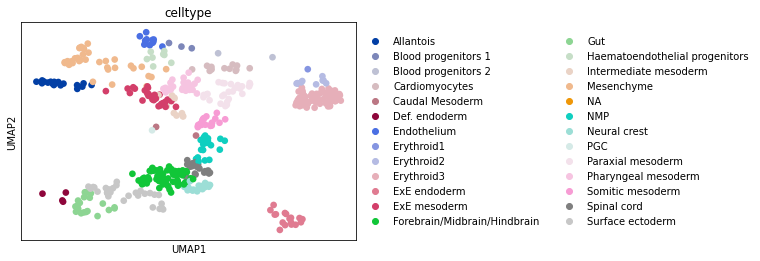

In [17]:
sc.pl.umap(adata_sc, color="celltype")

In [58]:
adata_sc.shape

(670, 17135)

In [59]:
adata_sc.shape

(670, 17135)

In [90]:
temp = [v for k, v in prob.solution.items()]

In [91]:
temp[0].solution.transport_matrix.shape

(670, 970)

In [77]:
adata_sp.shape

(970, 351)

In [45]:
prob._adata_sc

View of AnnData object with n_obs × n_vars = 670 × 10
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'sizeFactor', 'n_counts', '_scvi_batch', '_scvi_labels'
    var: 'ENSEMBL', 'SYMBOL', 'n_counts', 'overlap', 'marker', 'reference'
    uns: 'X_name', '_scvi', 'neighbors', 'umap'
    obsm: 'XY_cost', 'X_cost', 'X_scvi', 'X_umap', 'pca.corrected', 'umap'
    layers: 'ambiguous_counts', 'counts', 'spliced_counts', 'unspliced_counts'
    obsp: 'connectivities', 'distances'

In [ ]:
.prepare(sc_attr={'attr':'obsm', 'key':'X_scvi'},
                                                         sp_attr={'attr': 'obsm', 'key': 'spatial'},
                                                         atlas_attr={'sc_attr':'X', 'sp_attr':'X'},
                                                         keys_subset=marker_keys)

In [21]:
adata.obs.batch

0      0
1      0
2      0
3      0
4      0
      ..
195    1
196    1
197    1
198    1
199    1
Name: batch, Length: 200, dtype: int64

In [25]:
FGWSolver(gamma=0.1)

In [23]:
spap.prepare(key="batch")
# prepare("day", subset=[[1,2]], policy="sequential")

TypeError: __init__() missing 1 required positional argument: 'attr'